In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load the dataset
laptop_data = pd.read_csv('data/amazon_laptop_prices_v01.csv')

In [3]:
laptop_data.head()

,brand,model,screen_size,color,harddisk,cpu,ram,OS,special_features,graphics,graphics_coprocessor,cpu_speed,rating,price
0,ROKC,NaN,14 Inches,Blue,1000 GB,Intel Core i7,8 GB,Windows 11,NaN,Integrated,Intel,1.2 GHz,NaN,$589.99
1,HP,NaN,15.6 Inches,Silver,1000 GB,Intel Core i5,64 GB,Windows 11 Pro,Backlit Keyboard,Integrated,Intel,NaN,4.5,$999.99
2,MSI,Vector GP66 12UGS-267,15.66 Inches,Core Black,NaN,Intel Core i9,32 GB,Windows 11 Home,NaN,Dedicated,NaN,1.8 GHz,5.0,"$1,599.00"
3,Apple,MacBook Air,13.3 Inches,Silver,256 GB,Unknown,8 GB,Mac OS,Backlit Keyboard,Integrated,NaN,NaN,4.8,$689.99
4,Apple,MacBook Air,15.3 Inches,Midnight,256 GB,Unknown,8 GB,Mac OS,NaN,Integrated,NaN,NaN,4.8,"$1,144.48"


In [4]:
# Get a concise summary of the dataframe
laptop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446 entries, 0 to 4445
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   brand                 4446 non-null   object 
 1   model                 3282 non-null   object 
 2   screen_size           4417 non-null   object 
 3   color                 3867 non-null   object 
 4   harddisk              3870 non-null   object 
 5   cpu                   4346 non-null   object 
 6   ram                   4385 non-null   object 
 7   OS                    4420 non-null   object 
 8   special_features      2054 non-null   object 
 9   graphics              4381 non-null   object 
 10  graphics_coprocessor  2574 non-null   object 
 11  cpu_speed             1520 non-null   object 
 12  rating                2174 non-null   float64
 13  price                 4441 non-null   object 
dtypes: float64(1), object(13)
memory usage: 486.4+ KB


In [5]:
# Get a quick overview of the numerical data
laptop_data.describe()

,rating
count,2174.000000
mean,4.086891
std,1.165337
min,1.000000
25%,4.000000
50%,4.500000
75%,5.000000
max,5.000000


In [6]:
# Check for missing values
missing_values = laptop_data.isnull().sum()
missing_values

brand                      0
model                   1164
screen_size               29
color                    579
harddisk                 576
cpu                      100
ram                       61
OS                        26
special_features        2392
graphics                  65
graphics_coprocessor    1872
cpu_speed               2926
rating                  2272
price                      5
dtype: int64

In [7]:
# Check for unique values in categorical columns
unique_values = {column: laptop_data[column].unique() for column in laptop_data.select_dtypes(include=['object']).columns}
unique_values

{'brand': array(['ROKC', 'HP', 'MSI', 'Apple', 'Acer', 'ASUS', 'acer', 'Gateway',
        'Lenovo', 'DELL', 'Dell', 'LG', 'Microsoft', 'SAMSUNG',
        'Carlisle FoodService Products', 'Gigabyte', 'Razer', 'Asus',
        'LENOVO', 'Panasonic', 'Toughbook', 'Corsair', 'Alienware', 'AWOW',
        'Quality Refurbished Computers', 'dell', 'IVIEW', 'hp', 'XPG',
        'Computer Upgrade King', 'CTL', 'Best Notebooks', 'LPT',
        'Goldengulf', 'lenovo', 'ONN', 'Latitude', 'VAIO', 'Luqeeg',
        'MICROTELLA', 'Elo', 'SHOXLAB', 'GizPro', 'MAINGEAR', 'Tocosy',
        'asus', 'XAMMUE', 'JTD', 'Mytrix', 'TOPOSH'], dtype=object),
 'model': array([nan, 'Vector GP66 12UGS-267', 'MacBook Air', ..., 'Ideapad 3 82H8',
        'Predator Helios 300', 'Inspiron 3510 Laptop'], dtype=object),
 'screen_size': array(['14 Inches', '15.6 Inches', '15.66 Inches', '13.3 Inches',
        '15.3 Inches', '16 Inches', '17.3 Inches', '11.6 Inches',
        '15 Inches', '13.4 Inches', '18 Inches', '17 Inche

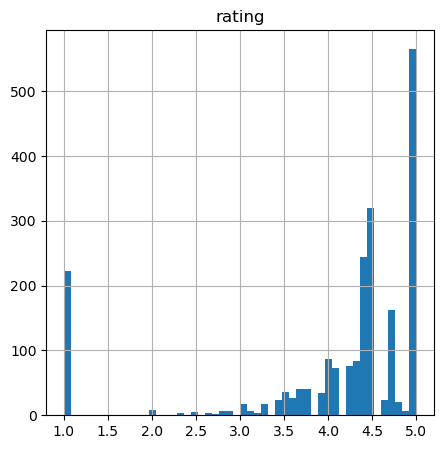

In [8]:
# Histograms for numerical columns
import matplotlib.pyplot as plt

laptop_data.hist(bins=50, figsize=(5,5))
plt.show()

# Some data preprocessing before continuing with EDA

In [9]:
# Remove ' Inches' and convert to numeric
laptop_data['screen_size'] = laptop_data['screen_size'].str.replace(' Inches', '').astype(float)

In [10]:
# Function to convert hard disk size to GB, handling missing values
def convert_to_gb(size):
    if pd.isnull(size):
        return np.nan
    elif 'TB' in size:
        return float(size.replace('TB', '').strip()) * 1000
    elif 'MB' in size:
        return float(size.replace('MB', '').strip()) / 1000
    else:
        return float(size.replace('GB', '').strip())

# Apply the function to the 'harddisk' column
laptop_data['harddisk'] = laptop_data['harddisk'].apply(convert_to_gb)

In [11]:
# Function to convert RAM size to GB, handling missing values and MB
def convert_ram_to_gb(ram):
    if pd.isnull(ram):
        return np.nan
    elif 'GB' in ram:
        return float(ram.replace('GB', '').strip())
    elif 'MB' in ram:
        return float(ram.replace('MB', '').strip()) / 1024  # Convert MB to GB
    else:
        return float(ram)  # In case there's a value with no unit

# Apply the function to the RAM column (replace 'RAM' with the actual column name)
laptop_data['ram'] = laptop_data['ram'].apply(convert_ram_to_gb)

In [12]:
# Combined function to handle ranges, outliers, and convert CPU speed to GHz
def clean_and_convert_cpu_speed(speed):
    if pd.isnull(speed):
        return np.nan
    # Handle speed ranges by taking the average
    if ',' in speed:
        speeds = speed.split(',')
        speed = str(sum(float(s.replace('GHz', '').replace('MHz', '').strip()) for s in speeds if 'GHz' in s or 'MHz' in s) / len(speeds))
    # Convert MHz to GHz by dividing by 1000
    if 'MHz' in speed:
        return float(speed.replace('MHz', '').strip()) / 1000
    elif 'GHz' in speed:
        # Remove 'GHz' and convert to float
        return float(speed.replace('GHz', '').strip())
    elif 'Hz' in speed:
        # Convert Hz to GHz by dividing by 1e9, or flag as an error if not in the expected range
        try:
            return float(speed.replace('Hz', '').strip()) / 1e9
        except ValueError:
            # If conversion fails, return NaN or some flag value for manual review
            return np.nan
    else:
        # If there's no unit, check if the value can be converted to a float
        try:
            return float(speed)
        except ValueError:
            # If conversion fails, return NaN or some flag value for manual review
            return np.nan

# Apply the function to the 'cpu_speed' column
laptop_data['cpu_speed'] = laptop_data['cpu_speed'].astype(str).apply(clean_and_convert_cpu_speed)

In [13]:
laptop_data.head()

,brand,model,screen_size,color,harddisk,cpu,ram,OS,special_features,graphics,graphics_coprocessor,cpu_speed,rating,price
0,ROKC,NaN,14.00,Blue,1000.0,Intel Core i7,8.0,Windows 11,NaN,Integrated,Intel,1.2,NaN,$589.99
1,HP,NaN,15.60,Silver,1000.0,Intel Core i5,64.0,Windows 11 Pro,Backlit Keyboard,Integrated,Intel,NaN,4.5,$999.99
2,MSI,Vector GP66 12UGS-267,15.66,Core Black,NaN,Intel Core i9,32.0,Windows 11 Home,NaN,Dedicated,NaN,1.8,5.0,"$1,599.00"
3,Apple,MacBook Air,13.30,Silver,256.0,Unknown,8.0,Mac OS,Backlit Keyboard,Integrated,NaN,NaN,4.8,$689.99
4,Apple,MacBook Air,15.30,Midnight,256.0,Unknown,8.0,Mac OS,NaN,Integrated,NaN,NaN,4.8,"$1,144.48"


In [14]:
# Define a mapping of specific colors to general colors
color_mapping = {
    'blue': ['blue', 'abyss blue', 'quiet blue', 'celestial blue', 'neptune blue', 'sky', 'horizon blue',
             'ai blue', 'ice blue', 'indigo blue', 'phantom blue', 'mist blue', 'titanium blue', 
             'mystic blue', 'nocturne blue' , 'royal blue', 'poseidon blue', 'royal blue', 
             'silver blue', 'fog blue', 'fog blue'],
    'gray/silver': ['silver', 'space gray', 'eclipse gray', 'grey', 'gray', 'onyx grey', 'mineral silver', 
                    'arctic grey', 'natural silver', 'platinum', 'mecha gray', 'basalt grey', 'graphite', 
                    'platinum grey', 'slate gray', 'shadow grey', 'chalkboard gray', 'mercury', 'natural silver'
                    , 'cosmo gray', 'ash gray', 'dark grey', 'gray, platinum silver', 'graphite grey', 
                    'mica silver', 'mercury grey', 'platinum gray', 'modern gray', 'silver/black', 
                    'transparent silver', 'storm grey', 'mineral gray', 'pure silver', 'eclipse grey', 
                    'arctic gray', 'platinum silver', 'titan gray', 'slate grey', 'dark ash silver', 
                    'dark silver', 'dark shadow grey', 'titan gray dull', 'graphite gray', 'machined aluminum', 
                    'iron grey', 'charcoal gray', 'mineral grey', 'grey', 'carbon gray', 'metallic gray', 
                    'star gray', 'sliver', 'metallic gray', 'pure silver', 'pine grey', 'epic silver', 
                    'iron gray', 'grey, gray, platinum silver', 'aluminum', 'gray, grey, platinum silver', 
                    'grey, platinum silver', 'stormy grey', 'silver matte', 'dark grey', 
                    'machined aluminum display back and base in silver', 'cloud grey', 'gray, silver', 
                    'onyx grey', 'phantom grey', 'eclipse gray'],
    'black': ['core black', 'midnight', 'black', 'graphite black','star black', 'off black', 'midnight black',
              'indie black', 'tech black', 'mineral black', 'ink black', 'classic black', 'obsidian black ',
              'jade black', 'business black', 'glossy black', 'mystic black', 'galaxy black', 'matte black',
              'thunder black', 'abyss black', 'black paint', 'carbon black', 'shadow black' 'nightfall black',
              'onyx black', 'thunder black', 'obisidian black', 'carbon black', 'abyssal black'],
    'white': ['white', 'dynamic white', 'blizzard white', 'snow white', 'moonstone white','lunar white', 'snowflake white'],
    'red': ['fiesta red', 'burgundy red', 'resolute red','red', 'coral red']
}


# Function to map the color to the general color category
def map_color_to_general(color):
    # If color is NaN (which is a float), return 'Other'
    if pd.isnull(color):
        return 'Other'
    # Convert color to lowercase and strip leading/trailing whitespace
    color = color.lower().strip()
    for general_color, specific_colors in color_mapping.items():
        if color in specific_colors:
            return general_color
    return 'Other'  # Use 'Other' for colors that don't fit into the general categories

# Apply the mapping to the 'color' column
laptop_data['general_color'] = laptop_data['color'].apply(map_color_to_general)

# Check the result of the mapping
laptop_data['general_color'].value_counts()

black          1633
gray/silver    1347
Other           894
blue            551
white            15
red               6
Name: general_color, dtype: int64

In [15]:
laptop_data.head()

,brand,model,screen_size,color,harddisk,cpu,ram,OS,special_features,graphics,graphics_coprocessor,cpu_speed,rating,price,general_color
0,ROKC,NaN,14.00,Blue,1000.0,Intel Core i7,8.0,Windows 11,NaN,Integrated,Intel,1.2,NaN,$589.99,blue
1,HP,NaN,15.60,Silver,1000.0,Intel Core i5,64.0,Windows 11 Pro,Backlit Keyboard,Integrated,Intel,NaN,4.5,$999.99,gray/silver
2,MSI,Vector GP66 12UGS-267,15.66,Core Black,NaN,Intel Core i9,32.0,Windows 11 Home,NaN,Dedicated,NaN,1.8,5.0,"$1,599.00",black
3,Apple,MacBook Air,13.30,Silver,256.0,Unknown,8.0,Mac OS,Backlit Keyboard,Integrated,NaN,NaN,4.8,$689.99,gray/silver
4,Apple,MacBook Air,15.30,Midnight,256.0,Unknown,8.0,Mac OS,NaN,Integrated,NaN,NaN,4.8,"$1,144.48",black


In [16]:
# Get the top 20 most common CPU types
top_20_cpus = laptop_data['cpu'].value_counts().head(25)

# Display the top 20 CPU types
print(top_20_cpus)

Core i7                 828
Core i5                 605
Intel Core i5           571
Intel Core i9           426
Intel Core i7           395
Pentium                 191
Pentium N5000           172
Core i7 Family          172
Celeron N4000           143
Core i9                 142
Celeron                  74
AMD Ryzen 7              66
Core i5 Family           56
Core i3                  48
Ryzen 7                  40
Ryzen 5                  30
8032                     19
Intel Core i5-1135G7     17
Celeron N                17
Celeron N4020            16
Intel Core i3            15
AMD R Series             15
Core i3 Family           13
AMD A Series             13
Corei7-10750H            11
Name: cpu, dtype: int64


In [17]:
import re

# Define the key CPU patterns and their standardized categories
cpu_patterns = {
    'core i9': re.compile(r'\b(i9|core.*i9|intel.*i9)\b', re.IGNORECASE),
    'core i7': re.compile(r'\b(i7|core.*i7|intel.*i7)\b', re.IGNORECASE),
    'core i5': re.compile(r'\b(i5|core.*i5|intel.*i5)\b', re.IGNORECASE),
    'core i3': re.compile(r'\b(i3|core.*i3|intel.*i3)\b', re.IGNORECASE),
    'pentium': re.compile(r'\bpentium\b', re.IGNORECASE),
    'celeron': re.compile(r'\bceleron\b', re.IGNORECASE),
    'ryzen 7': re.compile(r'\b(ryzen.*7)\b', re.IGNORECASE),
    # Add more patterns if needed
}

# Function to match CPU names to standardized categories
def standardize_cpu_name(cpu_name):
    if pd.isnull(cpu_name):
        return np.nan
    
    cpu_name = cpu_name.lower()
    for category, pattern in cpu_patterns.items():
        if pattern.search(cpu_name):
            return category
    return 'Other'

# Standardize the 'cpu' column
laptop_data['standardized_cpu'] = laptop_data['cpu'].apply(standardize_cpu_name)

# Check the standardized CPU names
standardized_cpu_counts = laptop_data['standardized_cpu'].value_counts(dropna=False)
print(standardized_cpu_counts)

core i7    1451
core i5    1287
core i9     569
pentium     368
celeron     264
Other       200
ryzen 7     117
NaN         100
core i3      90
Name: standardized_cpu, dtype: int64


In [18]:
laptop_data['OS'].value_counts().head(25)

Windows 11                                                                  1199
Windows 11 Home                                                              988
Windows 11 Pro                                                               907
Windows 10 Pro                                                               453
Windows 10 Home                                                              446
Windows 10                                                                   142
Chrome OS                                                                    125
Mac OS                                                                        19
Windows 7 Professional                                                        16
Windows 11 S                                                                  14
Windows 10 S                                                                  14
Windows 7                                                                     12
Windows 10 Pro 64 Bit Multi-

In [19]:
# Define the key OS patterns and their standardized categories
os_patterns = {
    'Windows': re.compile(r'windows', re.IGNORECASE),
    'Mac OS': re.compile(r'mac\s*os|macos', re.IGNORECASE),
    'Chrome OS': re.compile(r'chrome\s*os', re.IGNORECASE),
}

# Function to match OS names to standardized categories
def standardize_os_name(os_name):
    if pd.isnull(os_name):
        return np.nan  # Use 'Other' for missing or unidentifiable OS names
    
    os_name = os_name.lower()
    for category, pattern in os_patterns.items():
        if pattern.search(os_name):
            return category
    return 'Other'

# Standardize the 'OS' column
laptop_data['standardized_os'] = laptop_data['OS'].apply(standardize_os_name)

# Check the standardized OS names
standardized_os_counts = laptop_data['standardized_os'].value_counts(dropna=False)
print(standardized_os_counts)

Windows      4253
Chrome OS     125
Mac OS         30
NaN            26
Other          12
Name: standardized_os, dtype: int64


In [20]:
laptop_data['graphics'].value_counts().head(25)

Integrated                    3021
Dedicated                      850
Iris Xe Graphics                89
Nvidia GeForce RTX 4070         30
UHD Graphics                    29
Nvidia GeForce RTX 3050 Ti      24
Integrated, Dedicated           22
Radeon Graphics                 20
Nvidia RTX A3000                20
Nvidia GeForce RTX 4090         17
Nvidia GeForce RTX 4060         13
Nvidia GeForce RTX 3050         11
Nvidia GeForce RTX 4050         10
Nvidia T1200                     9
Nvidia GeForce RTX A500          8
T550                             8
Nvidia RTX A2000                 7
Nvidia RTX A1000                 7
RTX A1000                        6
RTX A2000                        6
Nvidia GeForce RTX 3060          6
Nvidia Quadro RTX 3000           6
Nvidia RTX 2000 Ada              5
RTX 3060                         5
Radeon 680M Graphics             5
Name: graphics, dtype: int64

In [21]:
# Function to categorize GPU names into 'Integrated' or 'Dedicated'
def categorize_gpu(gpu_name):
    if pd.isnull(gpu_name):
        return np.nan  # Use 'Unknown' for missing GPU names

    gpu_name = gpu_name.lower()
    # Define keywords for dedicated GPUs
    dedicated_keywords = ['rtx', 'gtx', 'quadro', 'radeon rx', 'mx', 'arc']
    # Check if any of the dedicated GPU keywords are in the GPU name
    if any(keyword in gpu_name for keyword in dedicated_keywords):
        return 'Dedicated'
    else:
        return 'Integrated'  # Default to 'Integrated' if no dedicated keywords are found

# Apply the categorization function to the 'graphics' column
laptop_data['graphics_category'] = laptop_data['graphics'].apply(categorize_gpu)

# Check the result of the categorization
graphics_category_counts = laptop_data['graphics_category'].value_counts(dropna=False)
print(graphics_category_counts)

Integrated    4098
Dedicated      283
NaN             65
Name: graphics_category, dtype: int64


In [22]:
laptop_data['graphics_coprocessor'].value_counts().head(25)

Intel                         1348
NVIDIA GeForce RTX 3070        202
Intel Iris Xe Graphics         145
Intel Integrated Graphics      103
Intel UHD Graphics              98
AMD Radeon Graphics             40
Intel UHD Graphics 620          26
NVIDIA GeForce RTX 4070         25
NVIDIA GeForce RTX 3060         25
Intel HD Graphics 520           22
NVIDIA GeForce RTX 3050 Ti      22
Integrated Graphics             21
NVIDIA GeForce RTX 3050         18
Intel HD Graphics 400           17
NVIDIA GeForce RTX 4060         17
Intel Iris                      16
Intel UHD Graphics 600          15
NVIDIA GeForce RTX 3080         15
Intel HD Graphics 620           14
Intel HD Graphics               11
Nvidia RTX A1000                10
NVIDIA GeForce RTX 4080          9
AMD Radeon R5                    8
AMD Integrated Graphics          8
NVIDIA GeForce GTX 1060          8
Name: graphics_coprocessor, dtype: int64

In [23]:
# Function to categorize the graphics coprocessor names
def categorize_graphics_coprocessor(name):
    if pd.isnull(name):
        return np.nan  # Use 'Unknown' for missing names

    name = name.lower()
    if 'intel' in name:
        return 'Intel'
    elif 'nvidia' in name or 'geforce' in name or 'gtx' in name or 'rtx' in name:
        return 'NVIDIA'
    elif 'amd' in name or 'radeon' in name:
        return 'AMD'
    else:
        return 'Other'

# Apply the categorization function to the 'graphics_coprocessor' column
laptop_data['graphics_coprocessor_category'] = laptop_data['graphics_coprocessor'].apply(categorize_graphics_coprocessor)

# Check the result of the categorization
graphics_coprocessor_category_counts = laptop_data['graphics_coprocessor_category'].value_counts(dropna=False)
print(graphics_coprocessor_category_counts)

Intel     1907
NaN       1872
NVIDIA     510
AMD        105
Other       52
Name: graphics_coprocessor_category, dtype: int64


In [24]:
laptop_data['brand'].value_counts().head(25)

Dell         1581
HP            804
ROKC          637
MSI           473
Lenovo        308
ASUS          160
DELL          147
acer          108
LG             39
Apple          29
SAMSUNG        23
Microsoft      15
Alienware      14
Panasonic      12
Acer           11
Gigabyte       11
Toughbook      11
hp              6
Razer           6
LENOVO          6
lenovo          4
Latitude        3
Luqeeg          3
SHOXLAB         2
CTL             2
Name: brand, dtype: int64

In [25]:
# Define the key brand patterns and their standardized categories
brand_patterns = {
    'Dell': re.compile(r'dell', re.IGNORECASE),
    'HP': re.compile(r'\bhp\b', re.IGNORECASE),
    'ROKC': re.compile(r'rokc', re.IGNORECASE),
    'MSI': re.compile(r'msi', re.IGNORECASE),
    'Lenovo': re.compile(r'lenovo', re.IGNORECASE),
    'ASUS': re.compile(r'asus', re.IGNORECASE),
    'LG': re.compile(r'\blg\b', re.IGNORECASE),
    'Apple': re.compile(r'apple', re.IGNORECASE),
    'Samsung': re.compile(r'samsung', re.IGNORECASE),
    'Microsoft': re.compile(r'microsoft', re.IGNORECASE),
    'Alienware': re.compile(r'alienware', re.IGNORECASE),
}

# Function to match brand names to standardized categories
def standardize_brand_name(brand_name):
    if pd.isnull(brand_name):
        return np.nan  # Use 'Unknown' for missing brand names

    brand_name = brand_name.lower()
    for standard_brand, pattern in brand_patterns.items():
        if pattern.search(brand_name):
            return standard_brand
    return 'Other'  # Use 'Other' for brands that don't match any pattern

# Apply the standardization function to the 'brand' column
laptop_data['standardized_brand'] = laptop_data['brand'].apply(standardize_brand_name)

# Check the result of the standardization
standardized_brand_counts = laptop_data['standardized_brand'].value_counts(dropna=False)
print(standardized_brand_counts)

Dell         1730
HP            810
ROKC          637
MSI           473
Lenovo        318
Other         195
ASUS          163
LG             39
Apple          29
Samsung        23
Microsoft      15
Alienware      14
Name: standardized_brand, dtype: int64


In [26]:
laptop_data.head()

,brand,model,screen_size,color,harddisk,cpu,ram,OS,special_features,graphics,graphics_coprocessor,cpu_speed,rating,price,general_color,standardized_cpu,standardized_os,graphics_category,graphics_coprocessor_category,standardized_brand
0,ROKC,NaN,14.00,Blue,1000.0,Intel Core i7,8.0,Windows 11,NaN,Integrated,Intel,1.2,NaN,$589.99,blue,core i7,Windows,Integrated,Intel,ROKC
1,HP,NaN,15.60,Silver,1000.0,Intel Core i5,64.0,Windows 11 Pro,Backlit Keyboard,Integrated,Intel,NaN,4.5,$999.99,gray/silver,core i5,Windows,Integrated,Intel,HP
2,MSI,Vector GP66 12UGS-267,15.66,Core Black,NaN,Intel Core i9,32.0,Windows 11 Home,NaN,Dedicated,NaN,1.8,5.0,"$1,599.00",black,core i9,Windows,Integrated,NaN,MSI
3,Apple,MacBook Air,13.30,Silver,256.0,Unknown,8.0,Mac OS,Backlit Keyboard,Integrated,NaN,NaN,4.8,$689.99,gray/silver,Other,Mac OS,Integrated,NaN,Apple
4,Apple,MacBook Air,15.30,Midnight,256.0,Unknown,8.0,Mac OS,NaN,Integrated,NaN,NaN,4.8,"$1,144.48",black,Other,Mac OS,Integrated,NaN,Apple


In [27]:
laptop_data.drop(columns=['brand','model','color','cpu','ram','OS','special_features','graphics','graphics_coprocessor'], axis=1, inplace=True)

In [28]:
laptop_data.head()

,screen_size,harddisk,cpu_speed,rating,price,general_color,standardized_cpu,standardized_os,graphics_category,graphics_coprocessor_category,standardized_brand
0,14.00,1000.0,1.2,NaN,$589.99,blue,core i7,Windows,Integrated,Intel,ROKC
1,15.60,1000.0,NaN,4.5,$999.99,gray/silver,core i5,Windows,Integrated,Intel,HP
2,15.66,NaN,1.8,5.0,"$1,599.00",black,core i9,Windows,Integrated,NaN,MSI
3,13.30,256.0,NaN,4.8,$689.99,gray/silver,Other,Mac OS,Integrated,NaN,Apple
4,15.30,256.0,NaN,4.8,"$1,144.48",black,Other,Mac OS,Integrated,NaN,Apple


In [29]:
missing_values = laptop_data.isnull().sum()
missing_values

screen_size                        29
harddisk                          576
cpu_speed                        2926
rating                           2272
price                               5
general_color                       0
standardized_cpu                  100
standardized_os                    26
graphics_category                  65
graphics_coprocessor_category    1872
standardized_brand                  0
dtype: int64

/var/folders/kk/r29wd8kj56g0l6y20z21b1680000gn/T/ipykernel_38888/4045174883.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = laptop_data.corr()


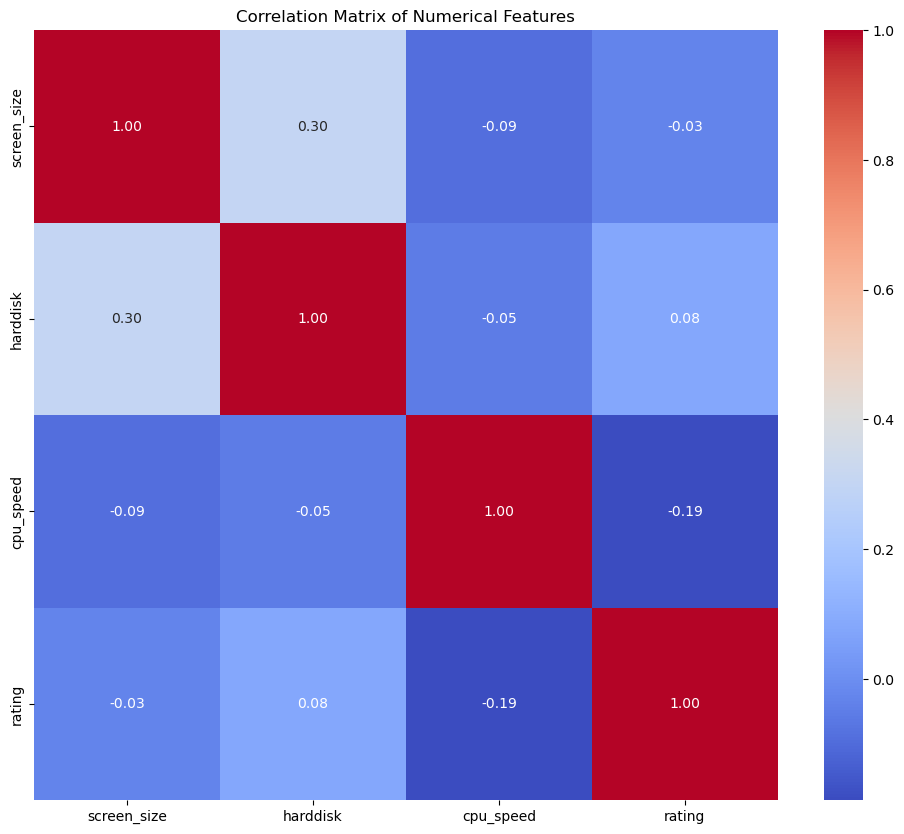

In [30]:
# Calculate the correlation matrix
correlation_matrix = laptop_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

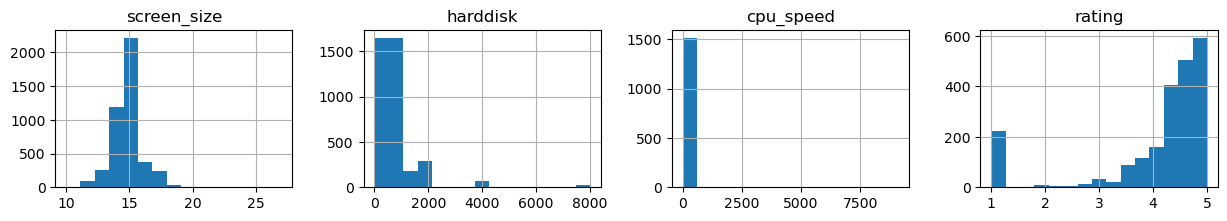

In [31]:
# Feature distribution
# Histograms for all numerical features
laptop_data.hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.show()

In [32]:
laptop_data.dropna(subset=['price'], inplace=True)

# Remove the dollar sign and commas from the 'price' column, then convert to float
laptop_data['price'] = laptop_data['price'].str.replace('[$,]', '', regex=True).astype(float)

# Now you can check the updated 'price' column to ensure it's numeric
print(laptop_data['price'].head())

0     589.99
1     999.99
2    1599.00
3     689.99
4    1144.48
Name: price, dtype: float64


In [33]:
# Calculate the median value of the 'screen_size' column
median_screen_size = laptop_data['screen_size'].median()

# Impute the missing values in 'screen_size' with the median value
laptop_data['screen_size'] = laptop_data['screen_size'].fillna(median_screen_size)

In [34]:
missing_values = laptop_data.isnull().sum()
missing_values

screen_size                         0
harddisk                          575
cpu_speed                        2921
rating                           2271
price                               0
general_color                       0
standardized_cpu                  100
standardized_os                    26
graphics_category                  64
graphics_coprocessor_category    1869
standardized_brand                  0
dtype: int64

In [35]:
laptop_data.dropna(subset=['standardized_cpu', 'standardized_os', 'graphics_category'], inplace=True)

In [36]:
# Calculate the median value of the 'harddisk' column
median_harddisk = laptop_data['harddisk'].median()

# Impute the missing values in 'harddisk' with the median value
laptop_data['harddisk'] = laptop_data['harddisk'].fillna(median_harddisk)

In [37]:
# Calculate the median 'cpu_speed' within each CPU category
median_cpu_speed_by_category = laptop_data.groupby('standardized_cpu')['cpu_speed'].transform('median')

# Impute the missing values in 'cpu_speed' with the median value of the corresponding CPU category
laptop_data['cpu_speed'] = laptop_data.apply(
    lambda row: median_cpu_speed_by_category[row.name] if pd.isnull(row['cpu_speed']) else row['cpu_speed'],
    axis=1
)

In [38]:
missing_values = laptop_data.isnull().sum()
missing_values

screen_size                         0
harddisk                            0
cpu_speed                           0
rating                           2187
price                               0
general_color                       0
standardized_cpu                    0
standardized_os                     0
graphics_category                   0
graphics_coprocessor_category    1780
standardized_brand                  0
dtype: int64

In [39]:
# Calculate the mode of the 'rating' column
mode_rating = laptop_data['rating'].mode()[0]

# Impute the missing values in 'rating' with the mode
laptop_data['rating'] = laptop_data['rating'].fillna(mode_rating)

In [40]:
laptop_data.drop(columns=['graphics_coprocessor_category'], axis=1, inplace=True)

In [41]:
missing_values = laptop_data.isnull().sum()
missing_values

screen_size           0
harddisk              0
cpu_speed             0
rating                0
price                 0
general_color         0
standardized_cpu      0
standardized_os       0
graphics_category     0
standardized_brand    0
dtype: int64

In [42]:
laptop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4282 entries, 0 to 4445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   screen_size         4282 non-null   float64
 1   harddisk            4282 non-null   float64
 2   cpu_speed           4282 non-null   float64
 3   rating              4282 non-null   float64
 4   price               4282 non-null   float64
 5   general_color       4282 non-null   object 
 6   standardized_cpu    4282 non-null   object 
 7   standardized_os     4282 non-null   object 
 8   graphics_category   4282 non-null   object 
 9   standardized_brand  4282 non-null   object 
dtypes: float64(5), object(5)
memory usage: 497.0+ KB


In [62]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Select categorical columns to encode
categorical_columns = ['general_color', 'standardized_cpu', 'standardized_os', 'graphics_category', 'standardized_brand']
categorical_data = laptop_data[categorical_columns]

# Fit and transform the data with the encoder
categorical_encoded = encoder.fit_transform(categorical_data)

# Save the encoder to a .pkl file for later use
with open('oh_encoder_laptop_1.pkl', 'wb') as file:
    pickle.dump(encoder, file)

# Convert the encoded features into a DataFrame
encoded_columns = encoder.get_feature_names_out(categorical_columns)
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoded_columns, index=laptop_data.index)

# Save the column order to a separate .pkl file for later use
with open('col_order_encoder_1.pkl', 'wb') as file:
    pickle.dump(categorical_columns, file)

/Users/javiertorres/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [63]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Select numerical columns to scale
numerical_columns = ['screen_size', 'harddisk', 'cpu_speed', 'rating']
numerical_data = laptop_data[numerical_columns]

# Fit and transform the data with the scaler
numerical_scaled = scaler.fit_transform(numerical_data)

# Save the scaler to a .pkl file for later use
with open('s_scaler_laptop_1.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Convert the scaled features into a DataFrame
numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_columns, index=laptop_data.index)

# Save the column order for the scaler to a separate .pkl file
with open('col_order_scaler_1.pkl', 'wb') as file:
    pickle.dump(numerical_columns, file)

In [50]:
# Concatenate the encoded categorical and scaled numerical features into one DataFrame
laptop_data_preprocessed = pd.concat([categorical_encoded_df, numerical_scaled_df], axis=1)

# Join the 'price' column with the laptop_data_preprocessed DataFrame on the index
laptop_data_preprocessed = laptop_data_preprocessed.join(laptop_data['price'])

In [53]:
X = laptop_data_preprocessed.drop('price', axis=1)  # Features
y = laptop_data_preprocessed['price']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Create the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=1, 
    n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {-best_score}")

# Get the best estimator directly
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best score: 220266.05190348098


In [58]:
# Make predictions on the training data
train_preds = best_rf_model.predict(X_train)

# Make predictions on the testing data
test_preds = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error on the training data
train_mse = mean_squared_error(y_train, train_preds)

# Calculate the Mean Squared Error on the testing data
test_mse = mean_squared_error(y_test, test_preds)

# Calculate the Root Mean Squared Error on the training data
train_rmse = np.sqrt(train_mse)

# Calculate the Root Mean Squared Error on the testing data
test_rmse = np.sqrt(test_mse)

print(f"RMSE on training data: {train_rmse}")
print(f"RMSE on testing data: {test_rmse}")

RMSE on training data: 365.67496328795886
RMSE on testing data: 447.5709066353288


In [61]:
with open('models/rf_laptop_1.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)